In [18]:
import pandas as pd
import numpy as np
import anndata as ad
import os
import sys
from collections import Counter
import gget
import scipy
from sklearn import preprocessing
import umap

import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

sc.settings.verbosity = 3

In [19]:
umap.__file__

'/home/cstansbu/.local/lib/python3.9/site-packages/umap/__init__.py'

# Load our data

In [20]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/anndata.clustered.h5ad"

adata = sc.read(fpath, cache=False)
adata.obs['cluster_name'] = adata.obs['clusters'].apply(lambda x: f"C{int(x) + 1}")
adata

/home/cstansbu/.local/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 8484 × 14936
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'clusters', 'cluster_name', 'UMAP 1', 'UMAP 2'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_name_colors', 'clusters_sizes', 'hvg', 'leiden', 'log1p', 'neighbors', 'paga', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

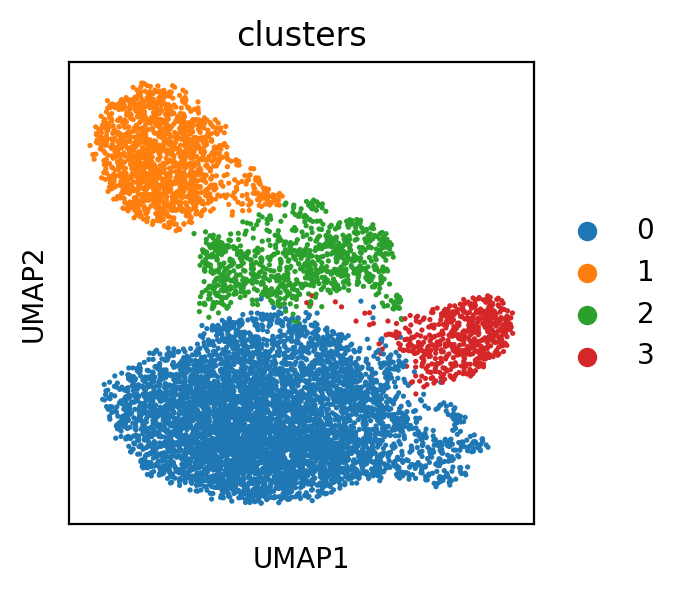

In [21]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3
sc.pl.umap(adata, color='clusters')

# Load tabula sapiens

In [22]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/adaptive_sampling/data/tabula_sapiens_filtered.h5ad"
sdf = sc.read_h5ad(fpath)

sc.pp.normalize_total(sdf, target_sum=1e6)

sdf

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 27346 × 58870
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'celltype', 'record_id', 'cell_id'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'log1p', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

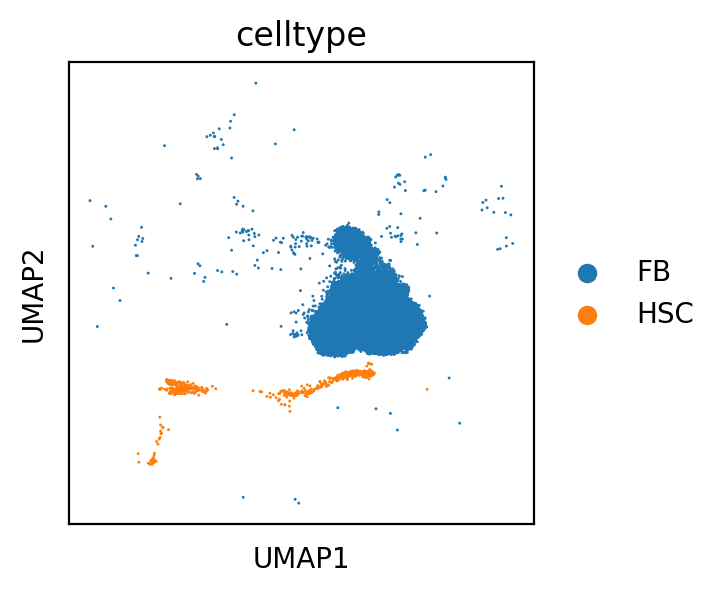

In [23]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3
sc.pl.umap(sdf, color='celltype')

In [24]:
sdf.obs[['celltype', 'organ_tissue']].value_counts()

celltype  organ_tissue   
FB        Fat                8459
          Vasculature        5867
          Bladder            5557
          Thymus             3924
          Trachea            1239
          Large_Intestine     953
HSC       Bone_Marrow         617
FB        Tongue              251
          Prostate            223
          Small_Intestine     113
HSC       Spleen               73
          Blood                70
Name: count, dtype: int64

# Marker genes

In [25]:
def getGenes(pdf, cellType, ui_upper=None):
    genes = pdf[pdf['cell type'] == cellType]
    
    if not ui_upper is None:
        genes = genes[genes['ubiquitousness index'] < ui_upper]
    return genes['official gene symbol'].to_list()


pdfPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/panglaodb/pandb.tsv.gz"
pandDf = pd.read_csv(pdfPath, sep="\t")

fb = getGenes(pandDf, 'Fibroblasts')
hp = getGenes(pandDf, 'Hematopoietic stem cells')

print(f"FB genes: {len(fb)}")
print(f"HP genes: {len(hp)}")

FB genes: 179
HP genes: 88


# get minimal overlapping gene set

In [26]:

ref_genes = sdf.var.copy()
data_genes = adata.var.copy()
data_genes = data_genes.reset_index(drop=False)


gene_df = pd.merge(data_genes[['gene_name', 'gene_id']],
                   ref_genes[['gene_symbol',]],
                   how='left',
                   left_on='gene_name',
                   right_on='gene_symbol')

gene_df['is_fb_marker'] = np.where(gene_df['gene_name'].isin(fb), True, False)
gene_df['is_hsc_marker'] = np.where(gene_df['gene_name'].isin(hp), True, False)

print(gene_df['is_fb_marker'].value_counts())
print()
print(gene_df['is_hsc_marker'].value_counts())
print()

gene_df.head()

is_fb_marker
False    14826
True       137
Name: count, dtype: int64

is_hsc_marker
False    14891
True        72
Name: count, dtype: int64



,gene_name,gene_id,gene_symbol,is_fb_marker,is_hsc_marker
0,ATAD3B,ENSG00000160072,ATAD3B,False,False
1,SKI,ENSG00000157933,SKI,False,False
2,PEX14,ENSG00000142655,PEX14,False,False
3,PLCH2,ENSG00000149527,PLCH2,False,False
4,SPSB1,ENSG00000171621,SPSB1,False,False


# combine data sets

In [27]:
def extract_objects(adata, sdf, gene_list):    
    our_data = adata[:, gene_list['gene_id'].to_list()]
    ref_data = sdf[:, gene_list['gene_symbol'].to_list()]
    return our_data, ref_data

def merge_counts(adata, sdf, gene_list, raw=True, sample=None):
    """A function to build a new anndata 
    object with the raw counts from both datasets """
    print(f"Using {gene_list.shape[0]} genes...")

    our_data, ref_data = extract_objects(adata, sdf, gene_list)

    if raw:
        print(f"extracting raw counts...")
        our_df = our_data.to_df(layer='counts')
        ref_df = ref_data.to_df(layer='raw_counts')
    else:
        our_df = our_data.to_df()
        ref_df = ref_data.to_df()
        
    # standardize the column names
    our_df.columns = gene_list['gene_name'].to_list()
    ref_df.columns = gene_list['gene_name'].to_list()
    
    # merge expression data
    data_df = pd.concat([our_df, ref_df])
    
    print(f"{our_df.shape=}")
    print(f"{ref_df.shape=}")
    print(f"{data_df.shape=}")

    # get observation data
    our_obs = our_data.obs.copy()
    our_obs['set'] = 'our_data'
    our_obs = our_obs[['cluster_name','set', 'UMAP 1', 'UMAP 2']]
    
    ref_obs = ref_data.obs.copy()
    ref_obs['set'] = 'ref_data'
    ref_obs = ref_obs[['organ_tissue', 'set', 'celltype']]
    
    # merge obs data
    obs_data = pd.concat([our_obs, ref_obs])
    
    print()
    print(f"{obs_data.shape=}")
    
    var_df = gene_list.copy()
    var_df = var_df.set_index('gene_name')

    print(f"{var_df.shape=}")
    
    data = sc.AnnData(data_df, 
                      var=var_df,
                      obs=obs_data)

    if not sample is None:
        data = sc.pp.subsample(data, fraction=sample, copy=True)

    return data

# all genes
mask = (gene_df['gene_symbol'].notna())
gene_list = gene_df[mask].reset_index(drop=True)

# # random genes
# mask = (gene_df['gene_symbol'].notna())
# gene_list = gene_df[mask].reset_index(drop=True)
# gene_list = gene_list.sample(1000)

data = merge_counts(adata, sdf, gene_list, sample=None)
data

Using 14599 genes...
extracting raw counts...
our_df.shape=(8484, 14599)
ref_df.shape=(27346, 14599)
data_df.shape=(35830, 14599)

obs_data.shape=(35830, 6)
var_df.shape=(14599, 4)


AnnData object with n_obs × n_vars = 35830 × 14599
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'

# Build merged data

In [28]:
# all genes
mask = (gene_df['gene_symbol'].notna())
gene_list = gene_df[mask].reset_index(drop=True)

data = merge_counts(adata, sdf, gene_list, sample=None)

# annotate raw data
data.layers["raw_counts"] = data.X.copy()

# # sample for testing
# data = sc.pp.subsample(data, n_obs=3000, copy=True)

data

Using 14599 genes...
extracting raw counts...
our_df.shape=(8484, 14599)
ref_df.shape=(27346, 14599)
data_df.shape=(35830, 14599)

obs_data.shape=(35830, 6)
var_df.shape=(14599, 4)


AnnData object with n_obs × n_vars = 35830 × 14599
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    layers: 'raw_counts'

In [29]:
# params
outpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/anndata.tabula.h5ad"
target_sum = 1e6
diffision = 2
magic_knn = 31
magic_solver = "approximate"

# simple preprocessing
sc.pp.normalize_total(data, target_sum=target_sum)
sc.pp.log1p(data)
data.layers["log_tpm"] = data.X.copy()

# # batch regression
# sc.pp.regress_out(data, keys='set')
# data.layers["batch_regression"] = data.X.copy() + data.X.min()

# batch correction
data.X = data.layers["log_tpm"].copy()
sc.pp.combat(data, key='set',) # regress out batch effects 
X = data.X.copy() 

# shift so min is zero
data.layers["combat_corrected"] = X + np.abs(X.min())

# # imputation
# sce.pp.magic(data, 
#              t=diffision, 
#              knn=magic_knn, solver=magic_solver,
#              name_list='all_genes')

# data.layers["imputed"] = data.X.copy()

# set the default data layer to be batch corrected, rather than imputed
# data.X = data.layers["combat_corrected"].copy()

data.write(outpath)

data

normalizing counts per cell
    finished (0:00:00)


... storing 'set' as categorical
... storing 'gene_id' as categorical


Standardizing Data across genes.

Found 2 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data



AnnData object with n_obs × n_vars = 35830 × 14599
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    uns: 'log1p'
    layers: 'raw_counts', 'log_tpm', 'combat_corrected'

In [30]:
data.to_df('raw_counts')[['CD34', 'FOS']].head()

gene_name,CD34,FOS
AAACCCAAGGTTACCT,2.0,0.0
AAACCCAAGTTGAAGT,0.0,0.0
AAACCCAAGTTGTCGT,0.0,0.0
AAACCCACAGAAGCGT,1.0,0.0
AAACCCACAGGAGGTT,0.0,0.0


In [31]:
data.to_df('combat_corrected')[['CD34', 'FOS']].head() 

gene_name,CD34,FOS
AAACCCAAGGTTACCT,37.481581,34.500826
AAACCCAAGTTGAAGT,31.060096,34.500826
AAACCCAAGTTGTCGT,31.060096,34.500826
AAACCCACAGAAGCGT,37.422741,34.500826
AAACCCACAGGAGGTT,31.060096,34.500826


In [32]:
x = data.to_df('combat_corrected')['CD34']
y = data.to_df('raw_counts')['CD34']

scipy.stats.pearsonr(x, y)

PearsonRResult(statistic=0.049578288072592666, pvalue=5.998380767477841e-21)

In [33]:
np.min(data.to_df('combat_corrected').to_numpy())

0.0

In [34]:
data.X.min()

-29.044990214543404